Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 300
Train set: 240, Test set: 60
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0398 - loss: 7.3241 - val_accuracy: 0.0500 - val_loss: 6.8260 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0533 - loss: 6.7420 - val_accuracy: 0.1000 - val_loss: 6.4039 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1145 - loss: 6.3166 - val_accuracy: 0.2333 - val_loss: 6.0186 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1497 - loss: 5.9374 - val_accuracy: 0.1667 - val_loss: 5.6808 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1792 - loss: 5.6045 - val_accuracy: 0.2333 - val_loss: 5.3789 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1953 - los

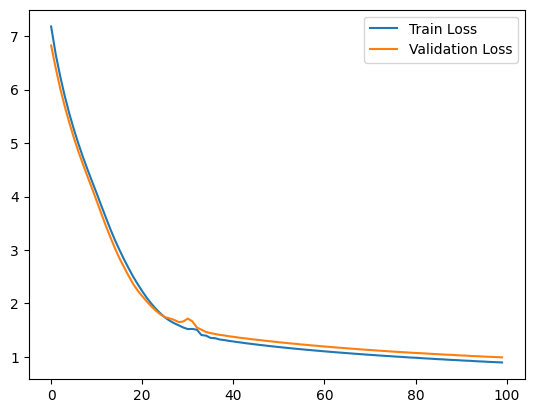

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9563 - loss: 0.9908
Test Results: [0.9928163290023804, 0.949999988079071]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
        Actual Font   Predicted Font  Actual Size  Predicted Size
0             Arial            Arial           16              16
1             Arial            Arial           32              32
2   Times New Roman  Times New Roman           32              32
3   Times New Roman  Times New Roman           16              16
4             Arial            Arial           16              16
5           Verdana          Verdana           16              16
6           Verdana          Verdana           24              24
7       Courier New      Courier New           24              24
8           Verdana          Verdana           24              24
9           Georgia          Georgia           24              24
10  Times New Roman  Times New Roman           24              24
11            Arial            Arial        

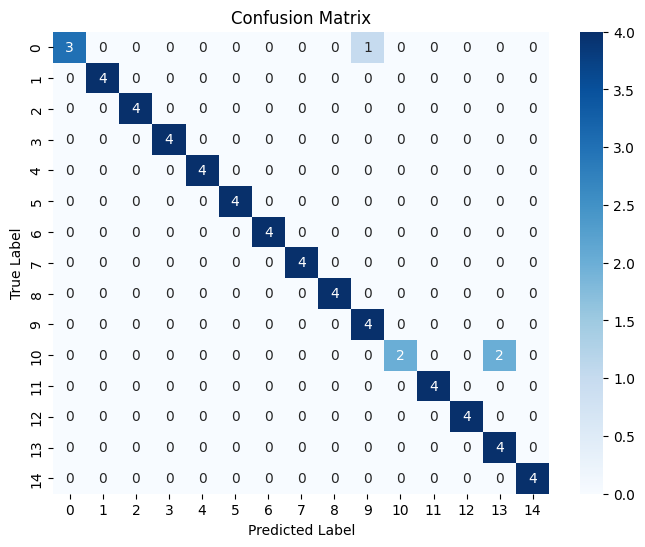

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from PIL import Image
import numpy as np
import os
import re
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

dataset_path = "/content/drive/MyDrive/BTP/text_image_dataset"
csv_path = "labels.csv"

# Load CSV file
data = pd.read_csv(csv_path)

# Font styles and sizes
fonts = ["Arial", "Times New Roman", "Courier New", "Verdana", "Georgia"]
sizes = [16, 24, 32]

# Create a unique class for each (font, size) combination
font_size_combinations = [(f, s) for f in range(len(fonts)) for s in sizes]
class_mapping = {comb: idx for idx, comb in enumerate(font_size_combinations)}

def extract_label_from_filename(filename):
    match = re.match(r'font_(\d+)_sample_\d+_size_(\d+)', filename)
    if match:
        font_class = int(match.group(1))
        size = int(match.group(2))
        return font_class, size
    return None, None

# Prepare dataset
images = []
labels = []

for index, row in data.iterrows():
    image_path = os.path.join(dataset_path, row['filename'])

    if os.path.exists(image_path):
        img = Image.open(image_path).convert("L")
        img = img.resize((32, 32))
        img = np.array(img) / 255.0

        font_class, size = extract_label_from_filename(row['filename'])
        if font_class is not None and size in sizes:
            combined_label = class_mapping[(font_class, size)]
            images.append(img)
            labels.append(combined_label)

# Convert to numpy arrays
images = np.array(images).reshape(-1, 32, 32, 1)
labels = to_categorical(labels, num_classes=len(font_size_combinations))

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Total images: {len(images)}")
print(f"Train set: {len(x_train)}, Test set: {len(x_test)}")

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# **Step 2: Increase Regularization (L2 & Dropout)**
def build_lenet():
    inputs = layers.Input(shape=(32, 32, 1))

    x = layers.Conv2D(6, (5, 5), activation='relu', padding='valid',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                      kernel_regularizer=l2(0.01)
                    )(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='valid',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                      kernel_regularizer=l2(0.01)
                    )(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                      kernel_regularizer=l2(0.01)
                    )(x)

    x = layers.Dense(84, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=seed),
                      kernel_regularizer=l2(0.01)
                    )(x)

    output = layers.Dense(len(font_size_combinations), activation='softmax', name='output',
                          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

model = build_lenet()

# **Step 4: Use a Smaller Learning Rate**
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate Model
test_results = model.evaluate(x_test, y_test)
print(f"Test Results: {test_results}")

# Predictions
predictions = model.predict(x_test)
predicted_indices = np.argmax(predictions, axis=1)
actual_indices = np.argmax(y_test, axis=1)

# Map back to font and size
predicted_classes = [font_size_combinations[idx] for idx in predicted_indices]
actual_classes = [font_size_combinations[idx] for idx in actual_indices]

predicted_fonts = [fonts[f] for f, s in predicted_classes]
actual_fonts = [fonts[f] for f, s in actual_classes]
predicted_sizes = [s for f, s in predicted_classes]
actual_sizes = [s for f, s in actual_classes]

# Display results
df_results = pd.DataFrame({
    "Actual Font": actual_fonts[:20],
    "Predicted Font": predicted_fonts[:20],
    "Actual Size": actual_sizes[:20],
    "Predicted Size": predicted_sizes[:20]
})

print(df_results)

# **Step 5: Confusion Matrix**
cm = confusion_matrix(actual_indices, predicted_indices)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(font_size_combinations)), yticklabels=range(len(font_size_combinations)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
